In [1]:
import pandas as pd
import dask.dataframe as dd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns

In [2]:
FF_dir = "/home/evos/Outputs/SKCM/FF/1_extract_histopathological_features/features.txt"
FF_features = pd.read_csv(FF_dir, sep="\t", index_col=0)
print(FF_features.columns)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1532', '1533', '1534', '1535', 'tile_ID', 'sample_submitter_id',
       'slide_submitter_id', 'Section', 'Coord_X', 'Coord_Y'],
      dtype='object', length=1542)


In [7]:
FFPE_dir = "/home/evos/Outputs/SKCM/FFPE/1_extract_histopathological_features/features_format_parquet"
FFPE_features = dd.read_parquet(f"{FFPE_dir}/features-*.parquet")
#FFPE_features = FFPE_dd.compute()
print(FFPE_features.columns)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1532', '1533', '1534', '1535', 'tile_ID', 'sample_submitter_id',
       'slide_submitter_id', 'Section', 'Coord_X', 'Coord_Y'],
      dtype='object', length=1542)


In [8]:
metadata_columns = ['tile_ID', 'sample_submitter_id', 'slide_submitter_id', 'Section', 'Coord_X', 'Coord_Y']  # Replace with actual metadata column names
FF_features_filtered = FF_features.drop(columns=metadata_columns)
FFPE_features_filtered = FFPE_features.drop(columns=metadata_columns)
#orion_gamma_UNI_features = orion_gamma_Fu.drop(columns=metadata_columns)

print(len(FF_features_filtered))
print(len(FFPE_features_filtered))
#print(len(orion_gamma_UNI_features))

244331
1468269


In [19]:
# Define a target size for subsampling (adjust based on memory limits)
target_size = 100000 # Total rows after subsampling (adjust as needed)

# Calculate subsample sizes proportionally
total_rows = sum([FF_features_filtered.shape[0], 1468269])
FF_sample_size = int((FF_features_filtered.shape[0] / total_rows) * target_size)
FFPE_sample_size = int((1468269 / total_rows) * target_size)
#orion_gamma_sample_size = int((orion_gamma_Fu_features.shape[0] / total_rows) * target_size)
print(FF_sample_size)
print(FFPE_sample_size)

14266
85733


In [21]:
# Subsample each dataset
FF_sample = resample(FF_features_filtered, n_samples=FF_sample_size, random_state=42)
def sample_partition(df, frac, random_state):
    return df.sample(frac=frac, random_state=random_state)
#FFPE_frac = FFPE_sample_size / len(FFPE_features_filtered)
FFPE_frac = FFPE_sample_size/1468269
FFPE_sample_dd = FFPE_features_filtered.map_partitions(sample_partition, frac=FFPE_frac, random_state=42)
FFPE_sample = FFPE_sample_dd.compute()

In [22]:
# Combine the subsamples
combined_sample = np.vstack([FF_sample, FFPE_sample])
#combined_sample = dd.concat([FF_sample, FFPE_sample])
labels_sample = (['FF'] * FF_sample_size + 
                 ['FFPE'] * FFPE_sample_size)
                 #['Orion_Gamma'] * orion_gamma_sample_size)

In [23]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_results = pca.fit_transform(combined_sample)

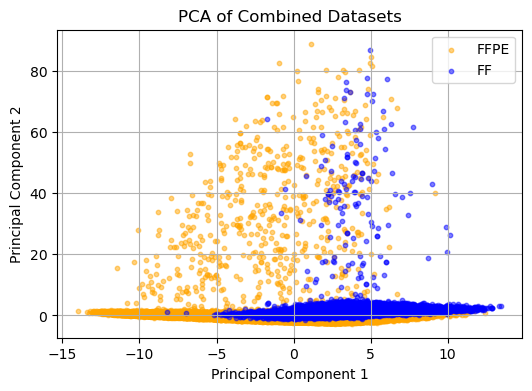

In [24]:
# Define consistent colors for each dataset
color_map = {
    'FF': 'blue',
    'FFPE': 'orange',
}

# Define dataset labels and ensure 'FF' is plotted last
dataset_labels = ['FFPE', 'FF']  # Adjust plotting order here
#dataset_labels = ['FF', 'Orion', 'Orion_Gamma']

plt.figure(figsize=(6, 4))
for label in dataset_labels:
    idx = [i for i, lbl in enumerate(labels_sample) if lbl == label]
    plt.scatter(pca_results[idx, 0], pca_results[idx, 1],
                label=label, alpha=0.5, s=10, color=color_map[label])

plt.title("PCA of Combined Datasets")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()